In [1]:
import os

cwd = os.getcwd()

if cwd.endswith('working'):
    PATH = os.path.join('/kaggle/input/', 'hanacaraka-roboflow')
    os.chdir(PATH)
    new_cwd = os.getcwd()

    print(f"The current working directory was: {cwd}")
    print(f"It has been changed to: {new_cwd}")

else:
    print(f"The current working directory is: {cwd}")

The current working directory was: /kaggle/working
It has been changed to: /kaggle/input/hanacaraka-roboflow


Load Training Data

In [2]:
import pandas as pd

train_df = pd.read_csv('train_classes.csv')
train_df.head()

,filename,ba,ca,da,dha,ga,ha,ja,ka,la,...,na,nga,nya,pa,ra,sa,ta,tha,wa,ya
0,na_original_na4-nando-png_047b8e4a-23d2-4984-9...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,ja131-pred3_png.rf.641be3c0db040a9ef0d9ca3e764...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ka_original_ka24-mine3-rm5-png_323626c9-08f4-4...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,wa169-pred-r10_png.rf.65c4b25eba5d8f672b9639ac...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,sa148-mine-rm5_png.rf.65b2c2b62e59d2eb71afea1b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [3]:
classes = train_df.columns[1:]

print(f"Classes: {classes}")

Classes: Index([' ba', ' ca', ' da', ' dha', ' ga', ' ha', ' ja', ' ka', ' la', ' ma',
       ' na', ' nga', ' nya', ' pa', ' ra', ' sa', ' ta', ' tha', ' wa',
       ' ya'],
      dtype='object')


In [4]:
train_df['label'] = train_df[classes].idxmax(axis=1)
train_df.drop(columns=classes, inplace=True)

train_df.head()

,filename,label
0,na_original_na4-nando-png_047b8e4a-23d2-4984-9...,na
1,ja131-pred3_png.rf.641be3c0db040a9ef0d9ca3e764...,ja
2,ka_original_ka24-mine3-rm5-png_323626c9-08f4-4...,ka
3,wa169-pred-r10_png.rf.65c4b25eba5d8f672b9639ac...,wa
4,sa148-mine-rm5_png.rf.65b2c2b62e59d2eb71afea1b...,sa


Load Validation Data

In [5]:
val_df = pd.read_csv('valid_classes.csv')
classes = val_df.columns[1:]
val_df['label'] = val_df[classes].idxmax(axis=1)
val_df.drop(columns=classes, inplace=True)

val_df.head()

,filename,label
0,ba_original_ba58-mine-r5-png_da355617-4601-42c...,ba
1,tha_original_tha59-mine-png_14942c0b-cf89-4c60...,tha
2,ca63-mine-b_png.rf.6651f23d5e3923e3f5869f5150a...,ca
3,wa_original_wa8-meki-b-png_71916382-2490-4423-...,wa
4,la_original_la9-meki-png_2fda8a06-5a2e-4631-b9...,la


Load Testing Data

In [6]:
test_df = pd.read_csv('test_classes.csv')
classes = test_df.columns[1:]
test_df['label'] = test_df[classes].idxmax(axis=1)
test_df.drop(columns=classes, inplace=True)

test_df.head()

,filename,label
0,ya_original_ya92-mine3-b-png_bbe9944d-6ddd-4bf...,ya
1,da86-mine_png.rf.11496a515f7f6cc4bec9df9340c77...,da
2,dha_original_dha90-mine3-b-png_10e4954e-1ddc-4...,dha
3,ka_original_ka83-mine3-b-png_a996444a-a42f-4b0...,ka
4,tha_original_tha97-mine3-png_446e0772-7dda-432...,tha


# Build the Data Generators (Data Augmentation)

In [7]:
label_encoded = {}

for i, label in enumerate(train_df['label'].unique()):
    label_encoded[label] = i
    
label_encoded

{' na': 0,
 ' ja': 1,
 ' ka': 2,
 ' wa': 3,
 ' sa': 4,
 ' nya': 5,
 ' dha': 6,
 ' pa': 7,
 ' nga': 8,
 ' tha': 9,
 ' ra': 10,
 ' ya': 11,
 ' da': 12,
 ' ca': 13,
 ' ha': 14,
 ' ga': 15,
 ' ta': 16,
 ' ma': 17,
 ' ba': 18,
 ' la': 19}

In [8]:
X_train = train_df['filename']
y_train = train_df['label']

X_val = val_df['filename']
y_val = val_df['label']

X_test = test_df['filename']
y_test = test_df['label']

print(f"{X_train.shape[0]} {X_val.shape[0]} {X_test.shape[0]}")

2700 800 400


In [9]:
from torch.utils.data import Dataset
from PIL import Image

class HanacarakaDataset (Dataset):
    def __init__(self, x, y, maps_label=label_encoded, transform=None):
        self.X = x
        self.y = y
        self.dicts = maps_label
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = Image.open('images/' + self.X.iloc[idx]).convert('RGB')
        label = self.dicts[self.y.iloc[idx]]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

In [10]:
import torchvision.transforms as transforms
import numpy as np
import cv2

from torch.utils.data import DataLoader

def cvt_grayscale(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    return Image.fromarray(img)

def cvt_rgb(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def erode_img(img, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    img = cv2.erode(np.array(img), kernel, iterations=1)
    return Image.fromarray(img)

def adaptive_threshold(img):
    img = cv2.adaptiveThreshold(np.array(img), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(img)

train_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    transforms.Lambda(adaptive_threshold),
    transforms.RandomRotation(10, fill=255),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.Lambda(cvt_rgb),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    transforms.Lambda(adaptive_threshold),
    transforms.Lambda(cvt_rgb),
    transforms.ToTensor(),
])

train_dataset = HanacarakaDataset(X_train, y_train, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = HanacarakaDataset(X_val, y_val, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = HanacarakaDataset(X_test, y_test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [11]:
feature, label = next(iter(train_loader))
feature.shape, len(train_loader)

(torch.Size([32, 3, 100, 100]), 85)

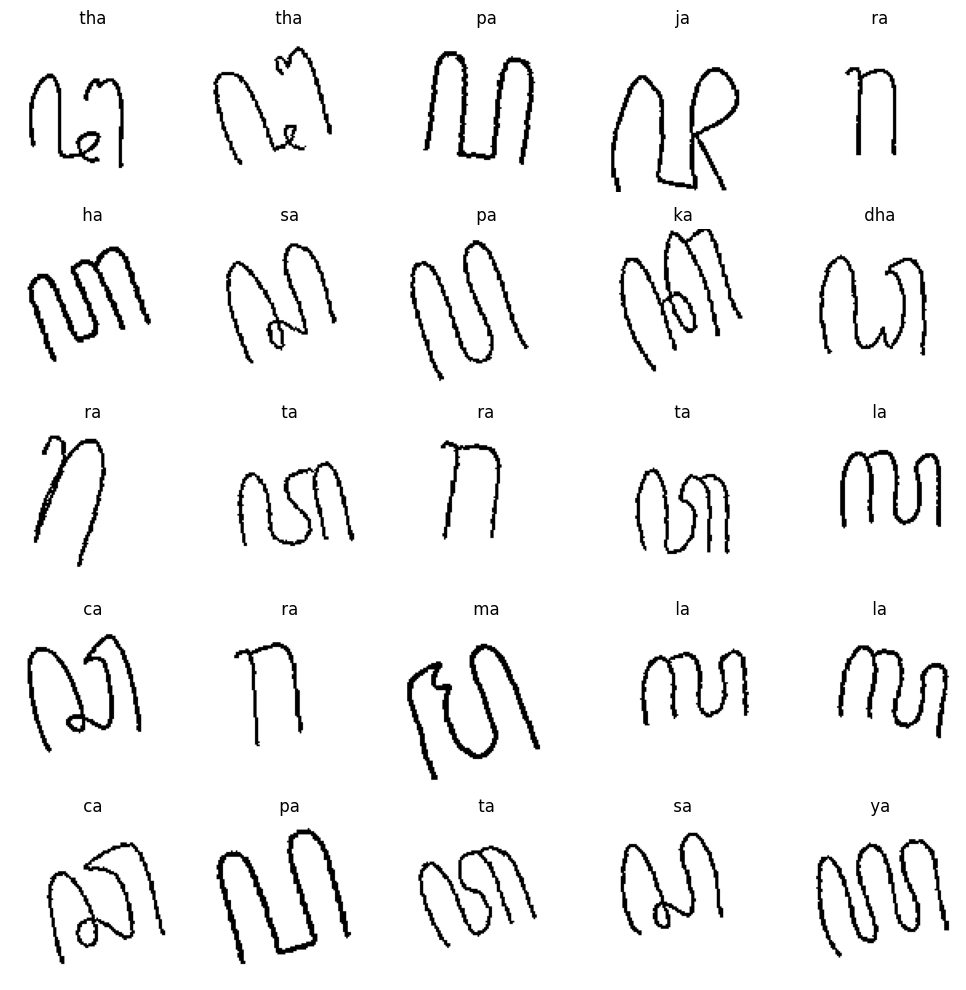

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for img, label, ax in zip(feature, label, axs.flatten()):
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    label = list(label_encoded.keys())[list(label_encoded.values()).index(label)]
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [13]:
import torch.nn as nn
from torchvision.models import MobileNet_V2_Weights
from torchvision.models import mobilenet_v2


class HanacarakaMobileNetV2(nn.Module):
    """
    MobileNetV3 were used as the baseline model. It's a CNN based architecture that were designed for mobile and edge devices.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        self.freeze()

        self.model.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [14]:
def train(
        model, train_loader, val_loader, criterion, optimizer, early_stop_epochs=5, max_epochs=20,
        history = None
):
    best_val_accuracy = 0.0
    best_epoch = 0
    epoch = 0

    while epoch < max_epochs:
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for feature, label in train_loader:
            feature, label = feature.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(feature)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for feature, label in val_loader:
                feature, label = feature.to(device), label.to(device)

                output = model(feature)
                loss = criterion(output, label)

                val_loss += loss.item()

                _, predicted = torch.max(output.data, 1)
                total_preds += label.size(0)
                correct_preds += (predicted == label).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds
        
        if history is not None:
            history.append((train_loss/len(train_loader), avg_val_loss))
        
        print(
            f'Epoch {epoch+1} | '
            f'Train Loss: {train_loss/len(train_loader):.4f} | '
            f'Val Loss: {avg_val_loss:.4f} | '
            f'Val Accuracy: {val_accuracy:.4f} | '
        )

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
        elif (epoch - best_epoch) >= early_stop_epochs:
            print('Early Stopping...')
            break

        epoch += 1

    return model

In [15]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HanacarakaMobileNetV2(num_classes=len(label_encoded)).to(device)
hist_train = []

criterion = nn.NLLLoss()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 85.9MB/s]


Learning Rate 1e-3

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

model = train(model, train_loader, val_loader, criterion, optimizer, early_stop_epochs = 2, max_epochs = 15, history=hist_train)

Epoch 1 | Train Loss: 2.5487 | Val Loss: 2.2086 | Val Accuracy: 0.3525 | 
Epoch 2 | Train Loss: 1.8219 | Val Loss: 1.9307 | Val Accuracy: 0.4175 | 
Epoch 3 | Train Loss: 1.5933 | Val Loss: 1.8354 | Val Accuracy: 0.4275 | 
Epoch 4 | Train Loss: 1.4774 | Val Loss: 1.7433 | Val Accuracy: 0.4575 | 
Epoch 5 | Train Loss: 1.3487 | Val Loss: 1.7732 | Val Accuracy: 0.4500 | 
Epoch 6 | Train Loss: 1.2878 | Val Loss: 1.6920 | Val Accuracy: 0.4775 | 
Epoch 7 | Train Loss: 1.2568 | Val Loss: 1.6481 | Val Accuracy: 0.4675 | 
Epoch 8 | Train Loss: 1.1919 | Val Loss: 1.6196 | Val Accuracy: 0.4875 | 
Epoch 9 | Train Loss: 1.1799 | Val Loss: 1.6352 | Val Accuracy: 0.5012 | 
Epoch 10 | Train Loss: 1.1741 | Val Loss: 1.5459 | Val Accuracy: 0.4975 | 
Epoch 11 | Train Loss: 1.1033 | Val Loss: 1.6099 | Val Accuracy: 0.4825 | 
Early Stopping...


Learning Rate 1e-4

In [17]:
model.unfreeze()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model = train(model, train_loader, val_loader, criterion, optimizer, early_stop_epochs = 6, max_epochs = 40, history=hist_train)

Epoch 1 | Train Loss: 0.8514 | Val Loss: 1.1136 | Val Accuracy: 0.6275 | 
Epoch 2 | Train Loss: 0.5352 | Val Loss: 0.9702 | Val Accuracy: 0.7050 | 
Epoch 3 | Train Loss: 0.3661 | Val Loss: 0.6876 | Val Accuracy: 0.7612 | 
Epoch 4 | Train Loss: 0.2636 | Val Loss: 0.6818 | Val Accuracy: 0.7488 | 
Epoch 5 | Train Loss: 0.1879 | Val Loss: 0.5303 | Val Accuracy: 0.8438 | 
Epoch 6 | Train Loss: 0.1524 | Val Loss: 0.5137 | Val Accuracy: 0.8325 | 
Epoch 7 | Train Loss: 0.1198 | Val Loss: 0.4885 | Val Accuracy: 0.8488 | 
Epoch 8 | Train Loss: 0.1076 | Val Loss: 0.4059 | Val Accuracy: 0.8725 | 
Epoch 9 | Train Loss: 0.0902 | Val Loss: 0.4387 | Val Accuracy: 0.8688 | 
Epoch 10 | Train Loss: 0.0708 | Val Loss: 0.3869 | Val Accuracy: 0.8825 | 
Epoch 11 | Train Loss: 0.0756 | Val Loss: 0.3730 | Val Accuracy: 0.8850 | 
Epoch 12 | Train Loss: 0.0521 | Val Loss: 0.3601 | Val Accuracy: 0.8850 | 
Epoch 13 | Train Loss: 0.0515 | Val Loss: 0.3456 | Val Accuracy: 0.8875 | 
Epoch 14 | Train Loss: 0.0328 | Va

Learning Rate 1e-5

In [18]:
model.unfreeze()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model = train(model, train_loader, val_loader, criterion, optimizer, early_stop_epochs = 10, max_epochs = 100, history=hist_train)

Epoch 1 | Train Loss: 0.0172 | Val Loss: 0.3348 | Val Accuracy: 0.9113 | 
Epoch 2 | Train Loss: 0.0113 | Val Loss: 0.3408 | Val Accuracy: 0.9113 | 
Epoch 3 | Train Loss: 0.0113 | Val Loss: 0.3225 | Val Accuracy: 0.9125 | 
Epoch 4 | Train Loss: 0.0117 | Val Loss: 0.3366 | Val Accuracy: 0.9087 | 
Epoch 5 | Train Loss: 0.0131 | Val Loss: 0.3279 | Val Accuracy: 0.9163 | 
Epoch 6 | Train Loss: 0.0112 | Val Loss: 0.3144 | Val Accuracy: 0.9213 | 
Epoch 7 | Train Loss: 0.0089 | Val Loss: 0.3225 | Val Accuracy: 0.9125 | 
Epoch 8 | Train Loss: 0.0111 | Val Loss: 0.3074 | Val Accuracy: 0.9187 | 
Epoch 9 | Train Loss: 0.0070 | Val Loss: 0.3204 | Val Accuracy: 0.9187 | 
Epoch 10 | Train Loss: 0.0133 | Val Loss: 0.3283 | Val Accuracy: 0.9200 | 
Epoch 11 | Train Loss: 0.0130 | Val Loss: 0.3300 | Val Accuracy: 0.9187 | 
Epoch 12 | Train Loss: 0.0076 | Val Loss: 0.3329 | Val Accuracy: 0.9137 | 
Epoch 13 | Train Loss: 0.0091 | Val Loss: 0.3173 | Val Accuracy: 0.9137 | 
Epoch 14 | Train Loss: 0.0116 | Va

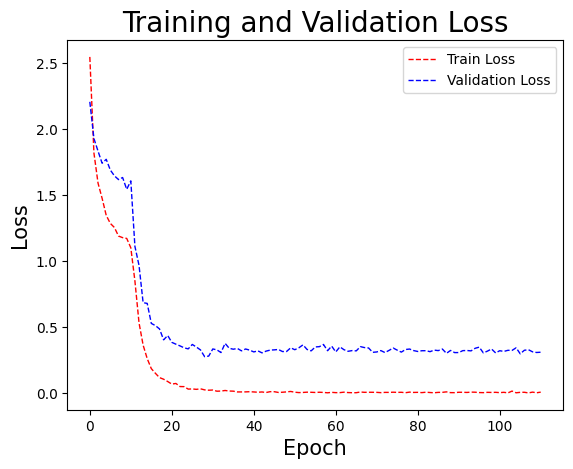

In [20]:
if hist_train:
    train_loss, val_loss = zip(*hist_train)
    
    plt.plot(train_loss, label='Train Loss', color='red', linestyle='dashed', linewidth=1)
    plt.plot(val_loss, label='Validation Loss', color='blue', linestyle='dashed', linewidth=1)
    plt.title('Training and Validation Loss', fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend()
    plt.show()

In [21]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for feature, label in test_loader:
            feature, label = feature.to(device), label.to(device)

            output = model(feature)
            _, predicted = torch.max(output, 1)

            total += label.size(0)
            correct += (predicted == label).sum().item()

    return correct/total

In [22]:
test(model, test_loader)

0.945

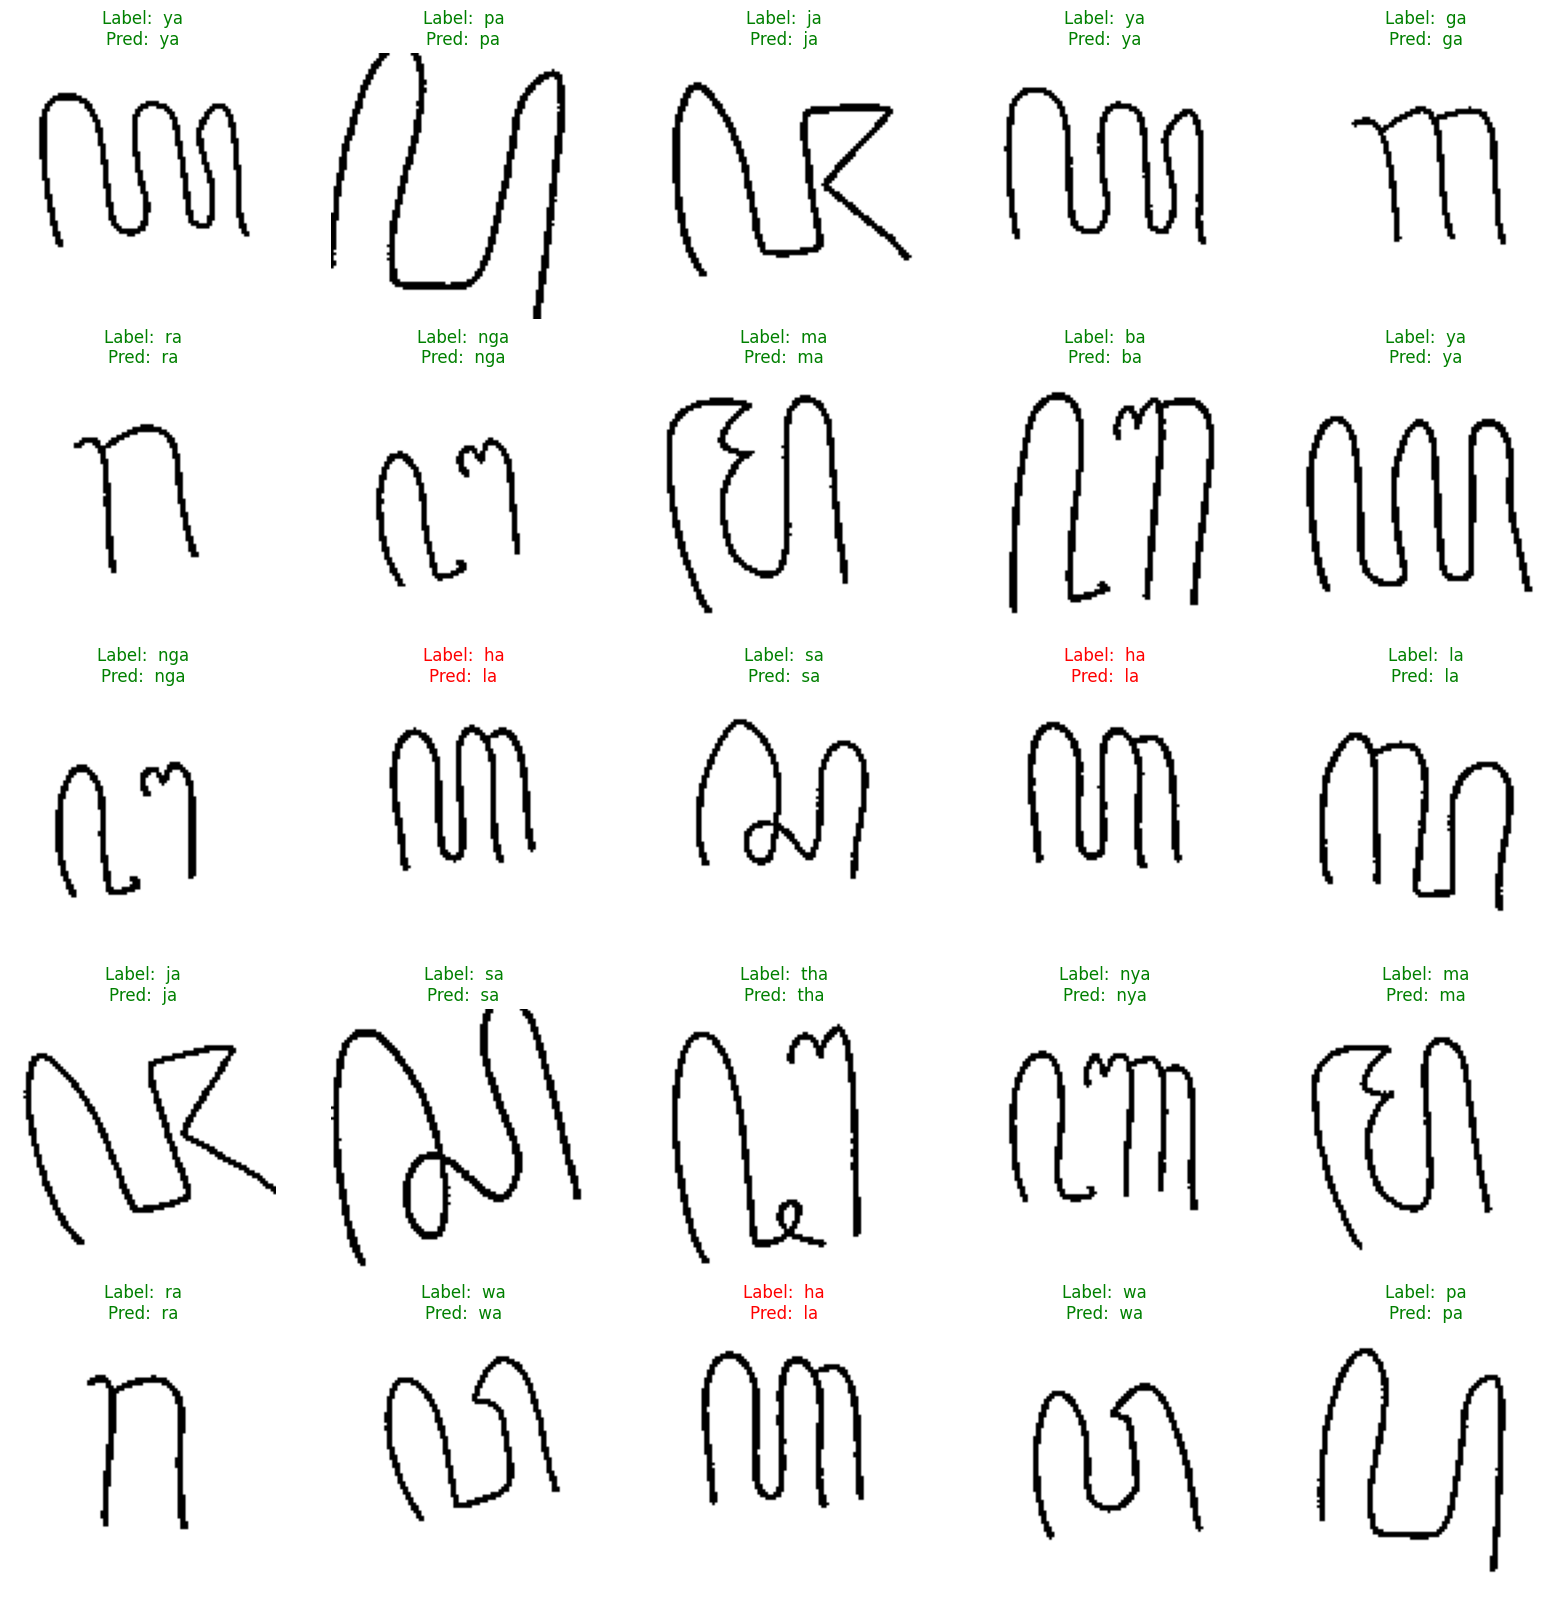

In [23]:
for feature, label in test_loader:
    feature, label = feature.to(device), label.to(device)
    output = model(feature)
    _, predicted = torch.max(output, 1)

    break

fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for img, label, pred, ax in zip(feature, label, predicted, axs.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu().squeeze(), cmap='gray')
    ax.axis('off')
    label = list(label_encoded.keys())[list(label_encoded.values()).index(label)]
    pred = list(label_encoded.keys())[list(label_encoded.values()).index(pred)]
    if label == pred:
        color = 'green'
    else:
        color = 'red'
    ax.set_title(f'Label: {label}\nPred: {pred}', color=color)